In [1]:
import pandas as pd
import geopandas as gpd
import folium
from shapely import geometry
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import mapclassify
from folium.plugins import MousePosition
from folium.plugins import Fullscreen
from folium.plugins import Search

In [ ]:
okn_pts = gpd.read_file('OKN_disconnect.geojson')
okn_poly = gpd.read_file('buildings_with_OKN.geojson')

total_bounds = okn_pts.total_bounds
minX, minY, maxX, maxY = total_bounds

square_size = 450

grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

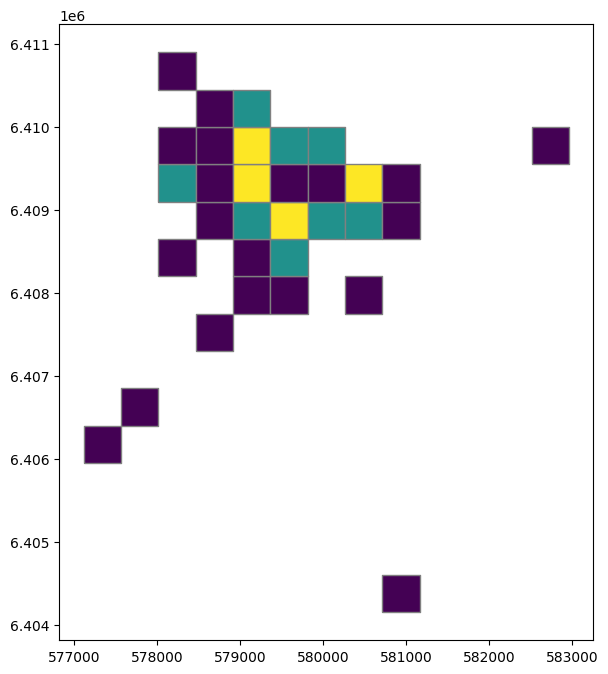

In [3]:
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32635')
fishnet['id'] = fishnet.index

merged = gpd.sjoin(okn_pts, fishnet, how='left', predicate='within')
merged['n'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[dissolve.index, 'n'] = dissolve.n.values

ax = fishnet.plot(column='n', figsize=(12, 8), cmap='viridis', scheme='natural_breaks', k=3, edgecolor="grey")

In [4]:
okn_pts_f = okn_pts.to_crs('EPSG:4326')
m = folium.Map(location=[okn_pts_f.centroid.y.mean(), okn_pts_f.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)

<ipython-input-4-8e357eac1fdc>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[okn_pts_f.centroid.y.mean(), okn_pts_f.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)
<ipython-input-4-8e357eac1fdc>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[okn_pts_f.centroid.y.mean(), okn_pts_f.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


In [5]:
folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='YlGnBu',
    fill_opacity = 0.5,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name="amount of heritage sites",
   name='Heritage Sites Concentration'
).add_to(m)

In [6]:
Poly_layer = folium.GeoJson(
    okn_poly,
    name="Heritage Buildings",
    tooltip=folium.GeoJsonTooltip(fields=['n_Объект']),
    popup=folium.GeoJsonPopup(fields=['n_address']),
    style_function=lambda x: {
        "fillColor": 'yellow'
    },
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=True,
    show=False,
).add_to(m)

In [7]:
Points_layer = folium.GeoJson(
    okn_pts,
    name="Heritage Sites",
    tooltip=folium.GeoJsonTooltip(fields=['Объект']),
    popup=folium.GeoJsonPopup(fields=['address']),
    style_function=lambda x: {
        "fillColor": 'yellow'
    },
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=False,
    show=False,
).add_to(m)

In [8]:
marker_cluster = MarkerCluster(name='Heritage Sites Cluster')
mc1= folium.plugins.FeatureGroupSubGroup(marker_cluster, 'Heritage Sites Cluster')
m.add_child(marker_cluster)
m.add_child(mc1)
mc1.add_child(folium.GeoJson(okn_pts,
                             show = False,
                             embed = False))

In [9]:
MousePosition().add_to(m)
Fullscreen(
    position="bottomright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)

In [10]:
Buildsearch = Search(
    layer=Poly_layer,
    geom_type="Polygon",
    placeholder="Heritage Buildings Search",
    collapsed=False,
    search_label="n_Объект",
    weight=3,
).add_to(m)

Pointsearch = Search(
    layer=Points_layer,
    geom_type="Point",
    placeholder="Heritage Sites Search",
    collapsed=True,
    search_label="Объект",
).add_to(m)

In [11]:
folium.LayerControl().add_to(m)

In [12]:
m

In [13]:
m.save("Pskov.html")